In [153]:
import os
import moviepy.editor as mp
import librosa
import joblib
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, save_model


In [140]:
import tensorflow as tf
import os
tf.config.list_physical_devices('GPU')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

# testing if gpu is used

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

cuda_malloc_async
Default GPU Device:/device:GPU:0


In [141]:
json_file = 'audio/metadata.json'
json_file2 = 'audio/metadata2.json'
json_file3 = 'audio/metadata3.json'
json_file4 = 'audio/metadata4.json'
json_file5 = 'audio/metadata5.json'
json_file6 = 'audio/metadata6.json'
json_file46 = 'audio/metadata46.json'
json_file47 = 'audio/metadata47.json'
json_file48 = 'audio/metadata48.json'
json_file49 = 'audio/metadata49.json'
json_file50 = 'audio/metadata50.json'
df = pd.read_json(json_file).T
df2 = pd.read_json(json_file2).T
df3 = pd.read_json(json_file3).T
df4 = pd.read_json(json_file4).T
df5 = pd.read_json(json_file5).T
df6 = pd.read_json(json_file6).T
df46 = pd.read_json(json_file46).T
df47 = pd.read_json(json_file47).T
df48 = pd.read_json(json_file48).T
df49 = pd.read_json(json_file49).T
df50 = pd.read_json(json_file50).T
df = pd.concat([df, df2, df3, df4, df5, df6, df46, df47, df48, df49, df50])
df['label'].value_counts()

label
FAKE    19605
REAL     3366
Name: count, dtype: int64

In [142]:
# resampling
fake_audio_df = df[df['label'] == 'FAKE']
real_audio_df = df[df['label'] == 'REAL']

# Determine the class with the fewer samples (assuming 'fake' class has fewer samples)
min_samples = min(len(fake_audio_df), len(real_audio_df))

# Resample both classes to have the same number of samples
fake_audio_resampled = fake_audio_df.sample(min_samples, replace = False, random_state = 0)
real_audio_resampled = real_audio_df.sample(min_samples, replace = False, random_state = 0)

# Concatenate the resampled DataFrames back together
balanced_df = pd.concat([fake_audio_resampled, real_audio_resampled], axis=0)

# Shuffle the rows in the balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state = 0)
balanced_df['label'].value_counts()


label
REAL    3366
FAKE    3366
Name: count, dtype: int64

In [143]:
X = []
y = []

# pre-processing
for index, row in balanced_df.iterrows():
    
    # video path
    label = row['label']
    video_path = os.path.join("audio/", index)
    
    # conversion to audio
    video = mp.VideoFileClip(video_path)
    
    if video.audio == None:
        print(video_path)
        continue
    
    try:
        audio = video.audio.to_soundarray()
    
    except:
        print(video_path)
        continue
    
    # MFCCs to extract audio
    mfccs = librosa.feature.mfcc(y=audio[:, 0], sr=audio.shape[0], n_mfcc=13)
    avg_mfccs = np.mean(mfccs, axis=1)
    
    # append to list
    X.append(avg_mfccs)
    y.append(label)

audio/ssoyfcbatv.mp4
audio/epphrlkqhp.mp4
audio/ubxlhztujz.mp4
audio/rbvqghnbez.mp4
audio/teehidqtii.mp4
audio/pjibpowymk.mp4


In [144]:
# encode y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=0.25, random_state=0)
len(X_train)

5044

In [126]:

# grid search train model
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    #'max_samples': [None, 0.5, 0.8]
}

rf = RandomForestClassifier(random_state = 0)
grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring = 'accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# get best hyperparams
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# best model
model = grid_search.best_estimator_

Best Hyperparameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}


In [148]:
# rf model
model = RandomForestClassifier(random_state = 0, bootstrap = True, class_weight = 'balanced_subsample',criterion = 'entropy', max_depth = 10, max_features = 'auto', 
                               min_samples_leaf = 5, min_samples_split = 2, n_estimators = 50)
model = model.fit(X_train, y_train)

In [115]:
# lgbm model
lgbm = lgb.LGBMClassifier(random_state = 0, criterion = 'entropy')
model = lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: criterion


Validation Accuracy: 0.7288941736028538


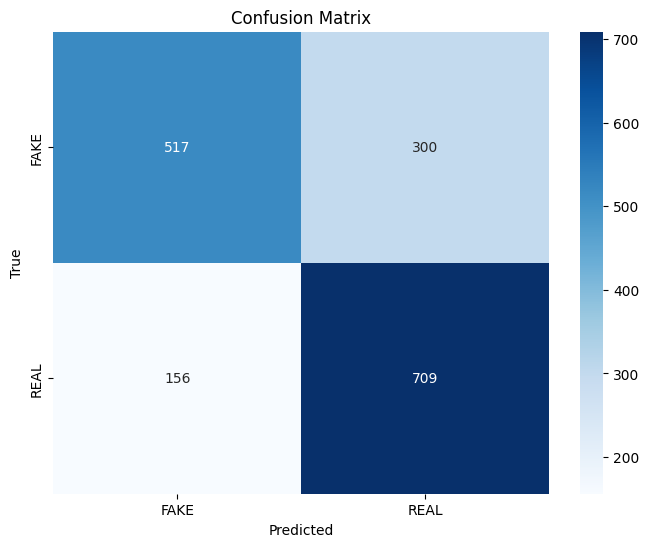

In [149]:
# model eval
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {accuracy}")

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [155]:
# save model
model_file_path = 'audio.pkl'
joblib.dump(model, model_file_path)

['audio.pkl']